<a href="https://www.kaggle.com/code/yutharsansivabalan/en3150-assignment-03-deepmind?scriptVersionId=281685909" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [63]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential 
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, Conv2D, MaxPooling2D, InputLayer
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.style.use('ggplot')

# 01 : Custom CNN 

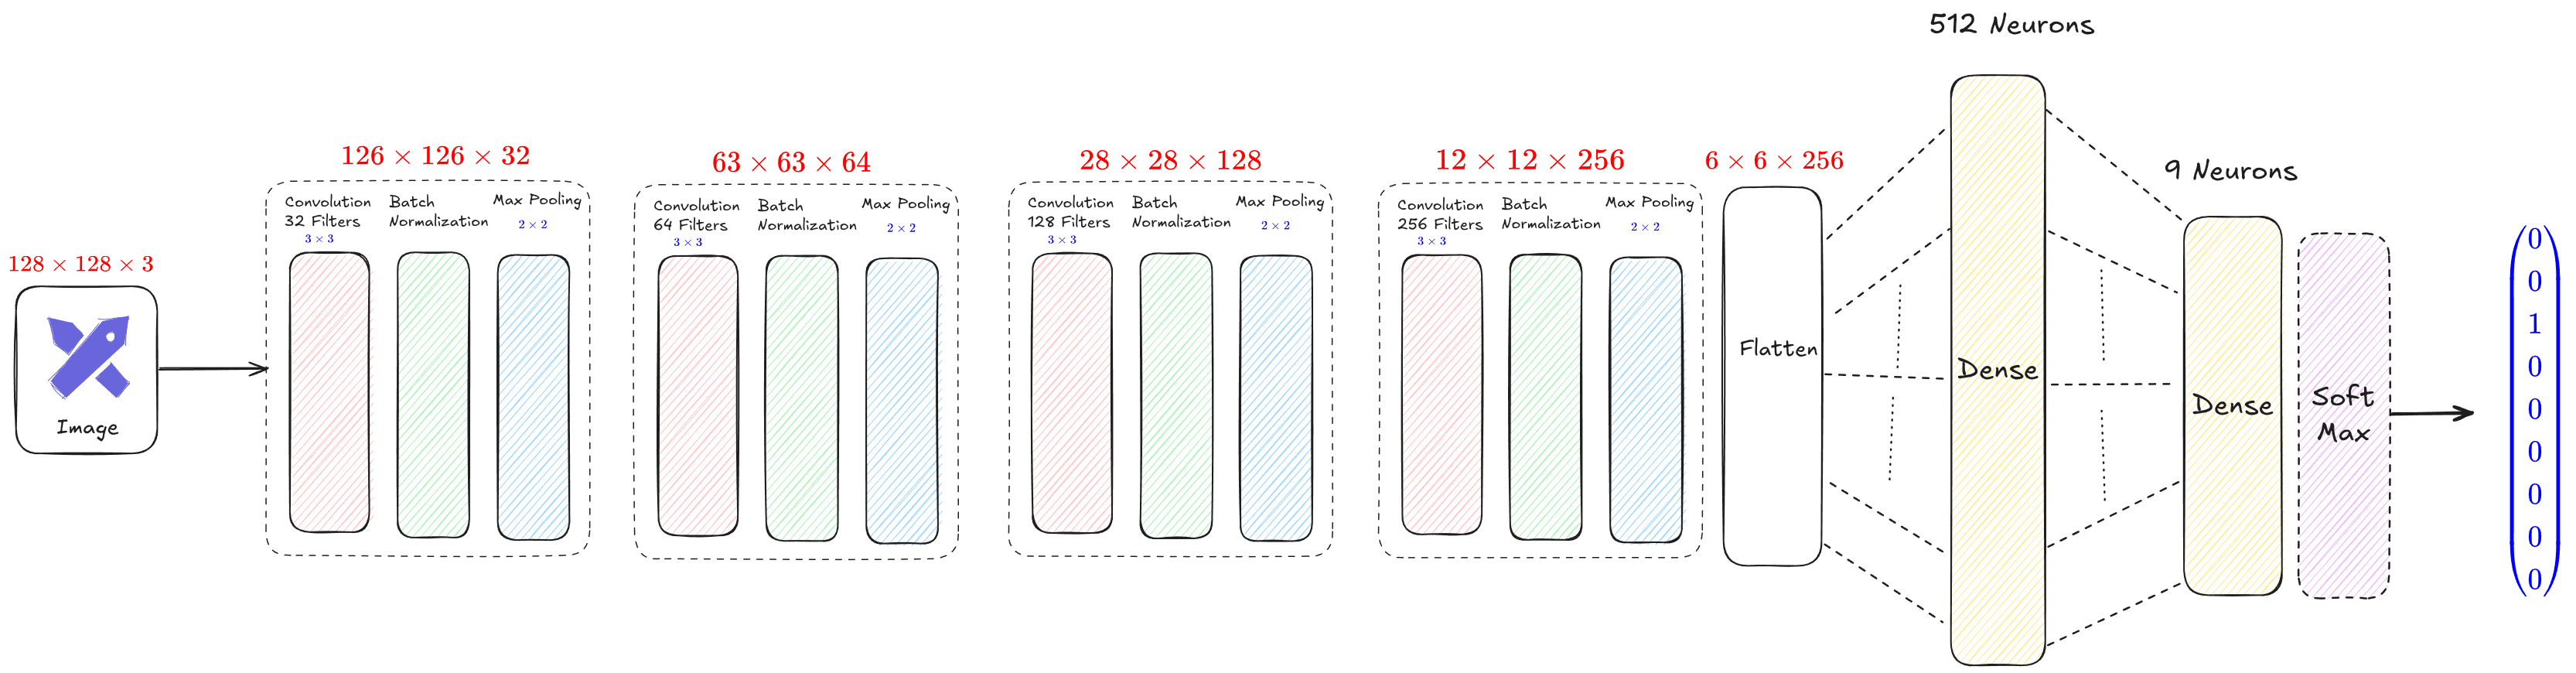

## Data Pre-Processing

In [32]:
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
img_size = (128, 128)
batch_size = 64

dataset = image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 4752 files belonging to 9 classes.


In [ ]:
# Split dataset (70/15/15)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Optimizer : ADAM

In [34]:
# CNN Model

def cnn_model(input_shape = (128, 128, 3)):
    """
    CNN model consists of 4 convolutional blocks with increasing spatial dropouts to facilitate regularization in deeper convolutional
    layers.
    ReLU activated dense layer with considerable dropout is applied for clasification
    SoftMax activated output layer produces one-hot encoded classification
    """

    model = Sequential()
    model.add(InputLayer(shape=input_shape))

    # Convolution Block 1 - 32 filters : max pooling
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Convolution Block 2 - 64 filters : max pooling : spatial dropout
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(SpatialDropout2D(0.1))

    # Convolution Block 3 - 128 filters : max pooling : spatial dropout
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(SpatialDropout2D(0.1))

    # Convolution Block 4 - 256 filters : max pooling : spatial dropout
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(SpatialDropout2D(0.2))

    # Flatten layer
    model.add(Flatten())
    # Dense layer - 512 neurons : dropout
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer - 9 neurons
    model.add(Dense(len(dataset.class_names), activation='softmax'))

    return model

In [35]:
model = cnn_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_9             │ (None, 30, 30, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_10            │ (None, 14, 14, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_11            │ (None, 6, 6, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,114,057 (19.51 MB)

 Trainable params: 5,113,097 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [36]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-8)


# Compile
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Training - Adam

In [37]:
# Train (20 epochs)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.3071 - loss: 5.2295 - val_accuracy: 0.0952 - val_loss: 8.7683 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4738 - loss: 1.5898 - val_accuracy: 0.1889 - val_loss: 4.5630 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5602 - loss: 1.3052 - val_accuracy: 0.1889 - val_loss: 4.1733 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5952 - loss: 1.1265 - val_accuracy: 0.2401 - val_loss: 3.3437 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6362 - loss: 1.0223 - val_accuracy: 0.4119 - val_loss: 2.1400 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6536 - loss: 0.9228 - val_accuracy: 0.5000 - val_loss: 1.6042 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6897 - loss: 0.8768 - val_a

### Accuracy and Loss - Adam

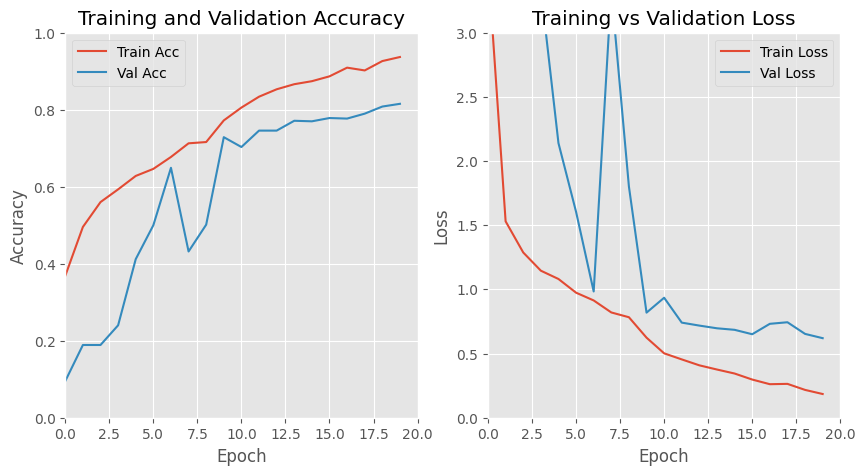

In [38]:
# Plot Accuracy SGD
figure, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 5))


plt1.plot(history.history['accuracy'], label='Train Acc')
plt1.plot(history.history['val_accuracy'], label='Val Acc')
plt1.set_title('Training and Validation Accuracy')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('Accuracy')
plt1.set_ylim(0, 1.0)
plt1.set_xlim(0, 20)
plt1.legend()

plt2.plot(history.history['loss'], label='Train Loss')
plt2.plot(history.history['val_loss'], label='Val Loss')
plt2.set_title('Training vs Validation Loss')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('Loss')
plt2.set_ylim(0, 3.0)
plt2.set_xlim(0, 20)
plt2.legend()

### Precision, Recall, and F1 Score - Adam

In [39]:
# Evaluate - Precision, recall, f1-score

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)

# Convert one hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=dataset.class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7533 - loss: 0.8371
Test Accuracy: 0.7500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
                     precision    recall  f1-score   support

          Cardboard       0.83      0.77      0.80        69
      Food Organics       0.67      0.79      0.73        57
              Glass       0.75      0.81      0.78        53
              Metal       0.73      0.77      0.75       131
Miscellaneous Trash       0.71      0.61      0.66        72
              Paper       0.69      0.72      0.70        67
            Plastic       0.74      0.74      0.74       143
      Textile Trash       0.77      0.65      0.71        55
         Vegetation       0.89      0.88      0.88        73

           accuracy                           0.75       720
          macro avg       0.75      0.75      0.75       720
       weighted avg       0.75      0.75      0.75       720



### Confusion Matrix - Adam

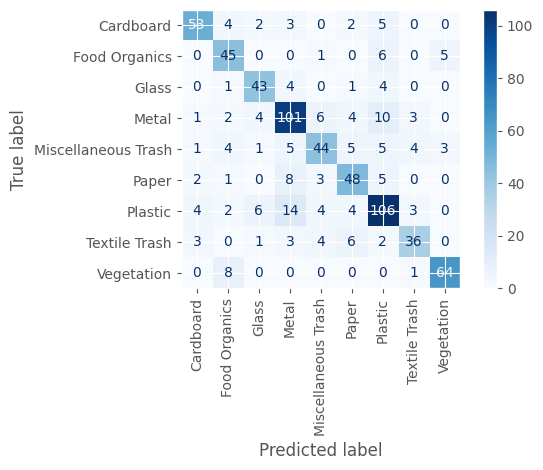

In [40]:
# Evaluate - Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.tight_layout()
plt.show()

## Optimizer : SGD

In [41]:
# Model with SGD as optimizer
model_sgd = cnn_model()

# Compile SGD
optimizer_sgd = keras.optimizers.SGD(learning_rate=0.001)
model_sgd.compile(optimizer=optimizer_sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd = model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.1473 - loss: 3.9887 - val_accuracy: 0.1151 - val_loss: 2.6573 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2745 - loss: 2.7210 - val_accuracy: 0.1960 - val_loss: 2.2502 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3383 - loss: 2.3226 - val_accuracy: 0.3608 - val_loss: 1.7839 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3664 - loss: 2.0649 - val_accuracy: 0.3580 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4221 - loss: 1.7996 - val_accuracy: 0.4730 - val_loss: 1.5181 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4091 - loss: 1.8046 - val_accuracy: 0.4943 - val_loss: 1.4491 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4372 - loss: 1.6981 - val_acc

### Accuray and Loss : SGD

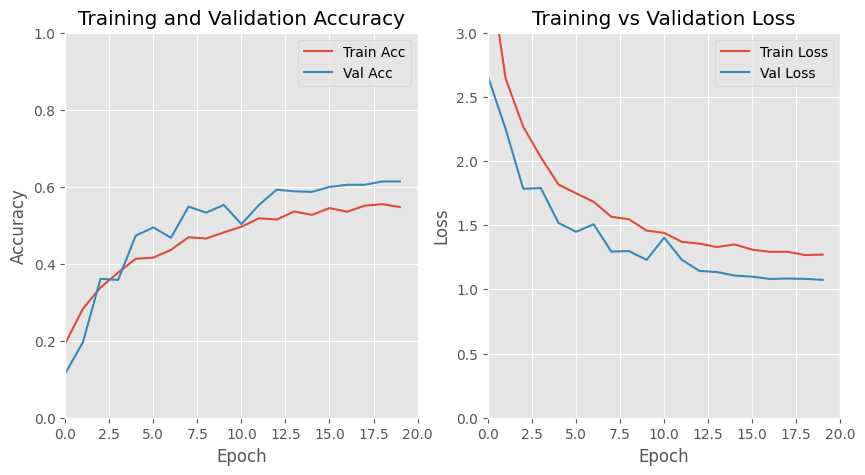

In [42]:
# Plot Accuracy SGD
figure, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 5))

plt1.plot(history_sgd.history['accuracy'], label='Train Acc')
plt1.plot(history_sgd.history['val_accuracy'], label='Val Acc')
plt1.set_title('Training and Validation Accuracy')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('Accuracy')
plt1.set_ylim(0, 1.0)
plt1.set_xlim(0, 20)
plt1.legend()

plt2.plot(history_sgd.history['loss'], label='Train Loss')
plt2.plot(history_sgd.history['val_loss'], label='Val Loss')
plt2.set_title('Training vs Validation Loss')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('Loss')
plt2.set_ylim(0, 3.0)
plt2.set_xlim(0, 20)
plt2.legend()

### Precision, Recall, and F1 Score - SGD

In [43]:
# Evaluate - Precision, recall, f1-score

test_loss, test_acc = model_sgd.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model_sgd.predict(test_ds)

# Convert one hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=dataset.class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5481 - loss: 1.2299
Test Accuracy: 0.5472
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
                     precision    recall  f1-score   support

          Cardboard       0.53      0.48      0.50        69
      Food Organics       0.51      0.68      0.58        57
              Glass       0.69      0.64      0.67        53
              Metal       0.51      0.63      0.56       131
Miscellaneous Trash       0.44      0.33      0.38        72
              Paper       0.50      0.45      0.47        67
            Plastic       0.54      0.54      0.54       143
      Textile Trash       0.55      0.22      0.31        55
         Vegetation       0.67      0.86      0.75        73

           accuracy                           0.55       720
          macro avg       0.55      0.54      0.53       720
       weighted avg       0.54      0.55      0.54       720



### Confusion Matrix - SGD


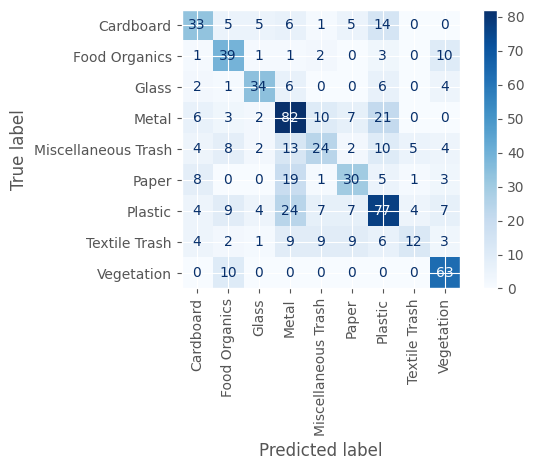

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.tight_layout()
plt.show()

## Optimizer : SGD with Momentum

In [45]:
# Model with SGD wit Momentum as optimizer
model_sgd_m = cnn_model()

# Compile SGD
optimizer_sgd_m = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)
model_sgd_m.compile(optimizer=optimizer_sgd_m,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd_m = model_sgd_m.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2034 - loss: 3.4152 - val_accuracy: 0.1435 - val_loss: 3.4040 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4132 - loss: 1.7930 - val_accuracy: 0.1662 - val_loss: 2.6131 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4917 - loss: 1.4771 - val_accuracy: 0.2358 - val_loss: 2.3041 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5322 - loss: 1.3626 - val_accuracy: 0.4119 - val_loss: 1.7132 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5731 - loss: 1.2179 - val_accuracy: 0.5412 - val_loss: 1.4427 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5829 - loss: 1.1877 - val_accuracy: 0.6222 - val_loss: 1.0844 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6037 - loss: 1.1205 - val_acc

### Accuracy and Loss - SGD with Momentum

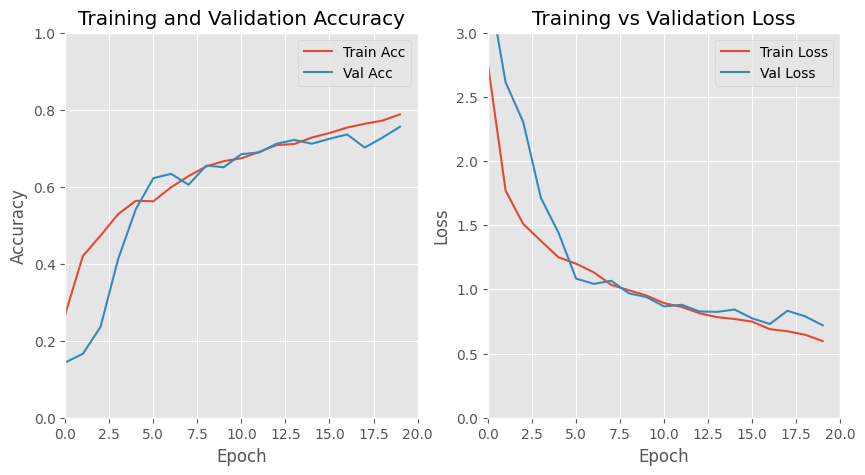

In [46]:
# Plot Accuracy SGD
figure, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 5))


plt1.plot(history_sgd_m.history['accuracy'], label='Train Acc')
plt1.plot(history_sgd_m.history['val_accuracy'], label='Val Acc')
plt1.set_title('Training and Validation Accuracy')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('Accuracy')
plt1.set_ylim(0, 1.0)
plt1.set_xlim(0, 20)
plt1.legend()

plt2.plot(history_sgd_m.history['loss'], label='Train Loss')
plt2.plot(history_sgd_m.history['val_loss'], label='Val Loss')
plt2.set_title('Training vs Validation Loss')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('Loss')
plt2.set_ylim(0, 3.0)
plt2.set_xlim(0, 20)
plt2.legend()

### Precision, Recall, and F1 Score - SGD with Momentum

In [47]:
# Evaluate - Precision, recall, f1-score

test_loss, test_acc = model_sgd_m.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model_sgd_m.predict(test_ds)

# Convert one hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=dataset.class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6655 - loss: 0.9371
Test Accuracy: 0.6736
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
                     precision    recall  f1-score   support

          Cardboard       0.80      0.59      0.68        69
      Food Organics       0.65      0.75      0.70        57
              Glass       0.76      0.72      0.74        53
              Metal       0.72      0.66      0.69       131
Miscellaneous Trash       0.58      0.49      0.53        72
              Paper       0.66      0.58      0.62        67
            Plastic       0.62      0.66      0.64       143
      Textile Trash       0.58      0.69      0.63        55
         Vegetation       0.71      0.95      0.81        73

           accuracy                           0.67       720
          macro avg       0.68      0.68      0.67       720
       weighted avg       0.68      0.67      0.67       720



### Confusion Matrix - SGD with Momentum

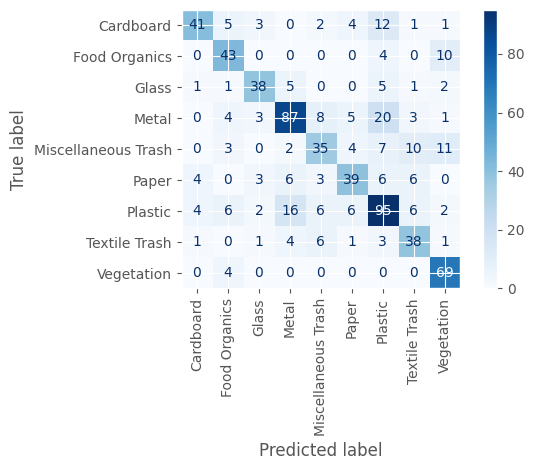

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.tight_layout()
plt.show()

# 02 : Comparision with State of The Art Models

## Model - 1 : DenseNet

In [49]:
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
img_size = (224, 224)
batch_size = 32

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # remaining 30% will be split into val+test
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Validation + Test dataset
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_batches = int(0.5 * len(temp_ds))
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.


### Data Preprocessing

In [50]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

# Preprocessing for DenseNet (normalize to ImageNet stats)
preprocess_input = tf.keras.applications.densenet.preprocess_input

def prepare_train(ds):
    return ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

def prepare_val_test(ds):
    return ds.map(lambda x, y: (x, y),
                  num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = prepare_train(train_ds).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = prepare_val_test(val_ds).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = prepare_val_test(test_ds).cache().prefetch(buffer_size=AUTOTUNE)

### Tranfer Learning - DenseNet

In [51]:
# Load DenseNet Pretrained Model (with 'imagenet' weights)
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

base_model.trainable = False # Freeze early layers

In [52]:
# Build improved classification head
inputs = base_model.input

# Preprocessing layer
x = preprocess_input(inputs)

# Base model
x = base_model(x, training=False)  # Keep batch norm in inference mode initially

# Enhanced classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

# Define full model
dense_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [53]:
es=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-8,
)

In [54]:
dense_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-4),
    metrics = ['accuracy'],
)

### Training - Densenet

In [55]:
history = dense_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds,
    callbacks = [es, lr]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 261ms/step - accuracy: 0.1977 - loss: 2.3690 - val_accuracy: 0.4730 - val_loss: 1.5162 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.4421 - loss: 1.5757 - val_accuracy: 0.5597 - val_loss: 1.2248 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5565 - loss: 1.2809 - val_accuracy: 0.6136 - val_loss: 1.0608 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6177 - loss: 1.1146 - val_accuracy: 0.6491 - val_loss: 0.9507 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6376 - loss: 1.0274 - val_accuracy: 0.6747 - val_loss: 0.8764 - learning_rate: 1.0000e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6858 - loss: 0.9266 - val_accuracy: 0.6960 - val_loss: 0.8356 - learning_rate: 1.0000e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step 

### Accuracy and Loss - DenseNet

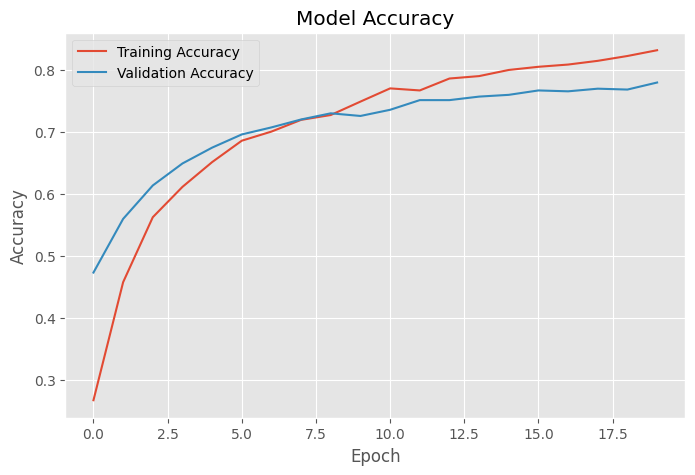

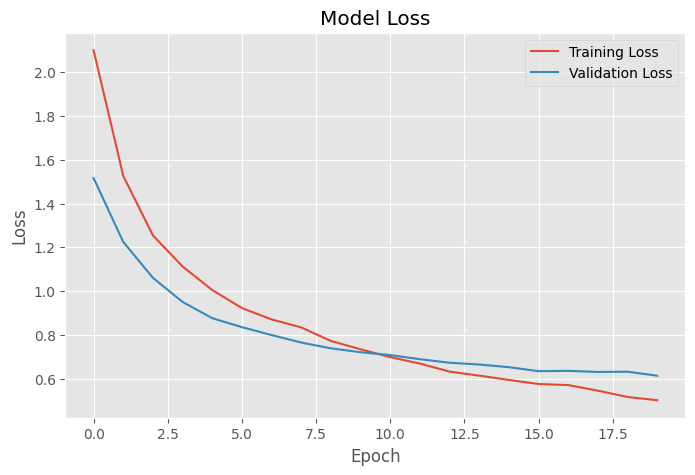

In [56]:
# Extract history
history = dense_model.history.history

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Best epoch (based on validation accuracy)
best_epoch = np.argmax(history['val_accuracy'])

best_train_acc = history['accuracy'][best_epoch]
best_val_acc = history['val_accuracy'][best_epoch]
best_train_loss = history['loss'][best_epoch]
best_val_loss = history['val_loss'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy: {best_train_acc * 100:.2f}%")
print(f"Validation Accuracy: {best_val_acc * 100:.2f}%")
print(f"Training Loss: {best_train_loss:.4f}")
print(f"Validation Loss: {best_val_loss:.4f}")

Best Epoch: 20
Training Accuracy: 83.20%
Validation Accuracy: 77.98%
Training Loss: 0.5019
Validation Loss: 0.6138


In [58]:
# Get class names
class_names = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]
print("Classes:", class_names)

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Precision, Recall, and F1 Score - DenseNet

In [59]:
# Gather true labels (works for batched tf.data)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Predictions (probabilities then class indices)
y_probs = dense_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_probs, axis=1)

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 558ms/step
                     precision    recall  f1-score   support

          Cardboard     0.7703    0.8769    0.8201        65
      Food Organics     0.7794    0.8833    0.8281        60
              Glass     0.8409    0.7255    0.7789        51
              Metal     0.8430    0.8430    0.8430       121
Miscellaneous Trash     0.7955    0.4667    0.5882        75
              Paper     0.8889    0.8421    0.8649        76
            Plastic     0.7953    0.8662    0.8293       157
      Textile Trash     0.8889    0.9600    0.9231        50
         Vegetation     0.8630    0.9545    0.9065        66

           accuracy                         0.8252       721
          macro avg     0.8295    0.8243    0.8202       721
       weighted avg     0.8255    0.8252    0.8193       721



### Confusion Matrix - DenseNet

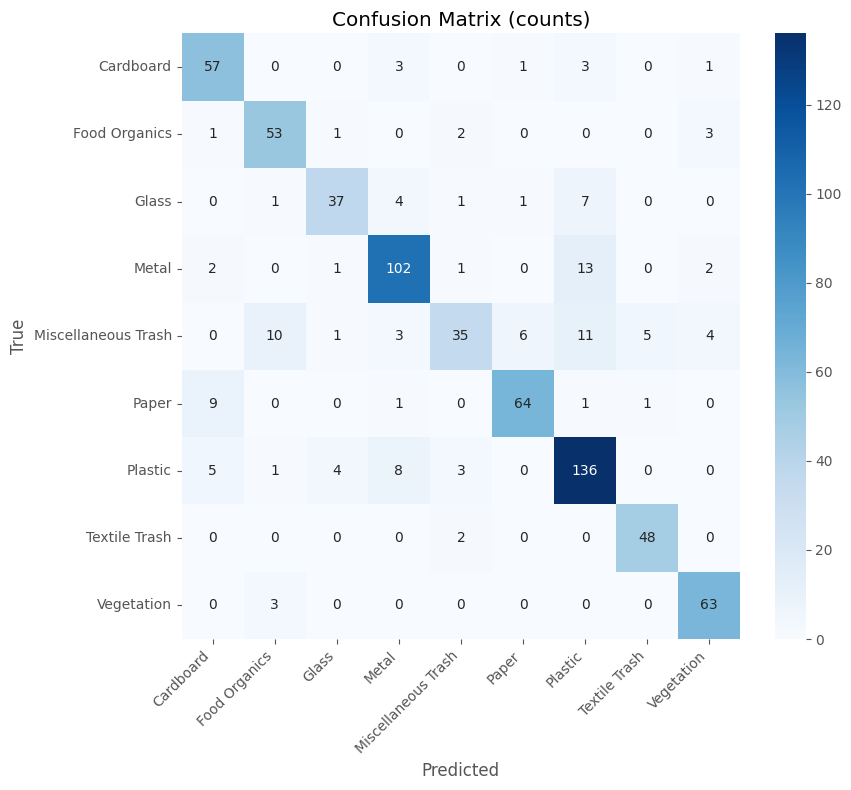

In [60]:
cm = confusion_matrix(y_true, y_pred)          # raw counts
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)  # per-row normalized (recall-wise)

# Plot raw confusion matrix
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Model - 2 : ResNet

### Transfer Learning - ResNet

In [64]:
# Load ResNet50 Pretrained Model (with 'imagenet' weights)
base_model = ResNet50( 
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

base_model.trainable = False # Freeze early layers

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [65]:
# Building the Full Model 
inputs = base_model.input

# Preprocessing layer 
x = base_model(inputs, training=False)  # Keep batch norm in inference mode initially

# Enhanced classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

# Define full model
resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs) 

In [66]:
# Defining Callbacks
es=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-8,
)

In [67]:
# Compiling the Model
resnet_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-4),
    metrics = ['accuracy'],
)

### Training - ResNet

In [68]:
# Training the Model 
history = resnet_model.fit( 
    train_ds,
    epochs = 20,
    validation_data = val_ds,
    callbacks = [es, lr]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.2398 - loss: 2.3260 - val_accuracy: 0.5554 - val_loss: 1.2206 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.5367 - loss: 1.2954 - val_accuracy: 0.6562 - val_loss: 0.9814 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.6378 - loss: 1.0500 - val_accuracy: 0.6591 - val_loss: 0.8964 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6871 - loss: 0.8991 - val_accuracy: 0.6932 - val_loss: 0.8548 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.7240 - loss: 0.7978 - val_accuracy: 0.6946 - val_loss: 0.8110 - learning_rate: 1.0000e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.7608 - loss: 0.7203 - val_accuracy: 0.7287 - val_loss: 0.7549 - learning_rate: 1.0000e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 10

### Accuracy and Loss - DenseNet

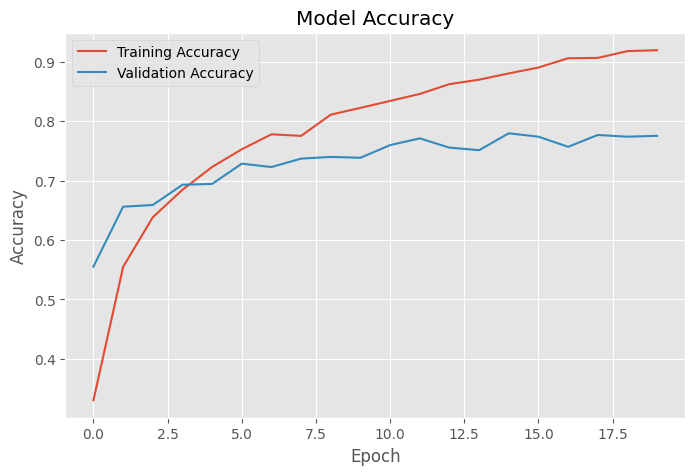

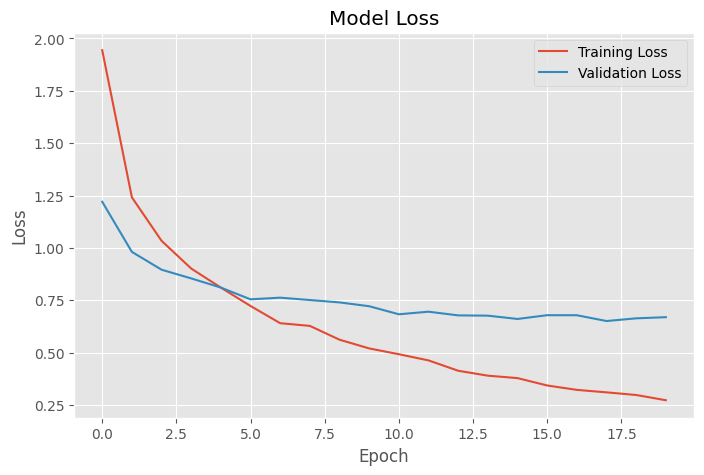

In [69]:
# Plotting Training History 

history_dict = history.history 

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Precision, Recall, and F1 Score - ResNet

In [70]:
# Gather true labels (works for batched tf.data)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Predictions (probabilities then class indices)
y_probs = resnet_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_probs, axis=1)

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step
                     precision    recall  f1-score   support

          Cardboard     0.7538    0.7538    0.7538        65
      Food Organics     0.9038    0.7833    0.8393        60
              Glass     0.7391    0.6667    0.7010        51
              Metal     0.7286    0.8430    0.7816       121
Miscellaneous Trash     0.7667    0.6133    0.6815        75
              Paper     0.7952    0.8684    0.8302        76
            Plastic     0.8026    0.7771    0.7896       157
      Textile Trash     0.9048    0.7600    0.8261        50
         Vegetation     0.7901    0.9697    0.8707        66

           accuracy                         0.7878       721
          macro avg     0.7983    0.7817    0.7860       721
       weighted avg     0.7911    0.7878    0.7859       721



### Confusion Matrix - ResNet

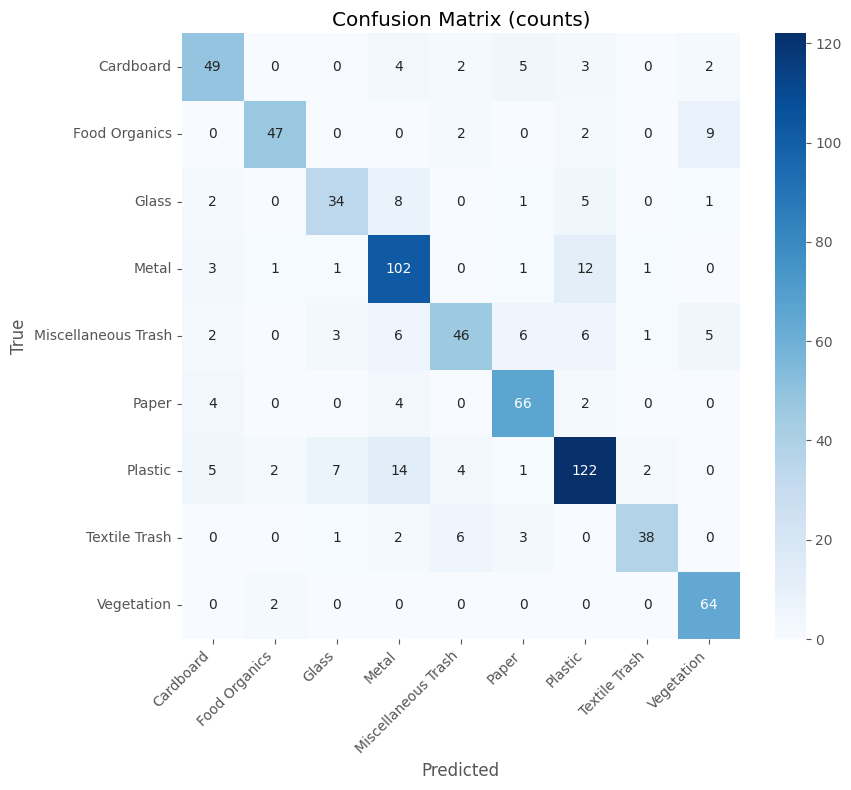

In [71]:
cm = confusion_matrix(y_true, y_pred) # raw counts
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)  # per-row normalized (recall-wise)

# Plot raw confusion matrix
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()